In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


LOADING DATASET


In [2]:
customers = pd.read_csv('/Users/varsharani/Downloads/Customers.csv')
products = pd.read_csv('/Users/varsharani/Downloads/Products.csv')
transactions = pd.read_csv('/Users/varsharani/Downloads/Transactions.csv')

In [3]:
# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [4]:
# Merge datasets
data = transactions.merge(customers, on='CustomerID',  how='left')

In [5]:
customer_data = data.groupby("CustomerID").agg({
    "TotalValue": ["sum", "mean", "count"],
    "Quantity": "sum"
}).reset_index()
customer_data.columns = ["CustomerID", "TotalSpending", "AvgTransactionValue", "TransactionCount", "TotalQuantity"]


In [6]:
# Merge aggregated metrics with customer profiles
customer_profile = pd.merge(customers, customer_data, on="CustomerID")

# Encode categorical variables (if any, e.g., Region)
customer_profile = pd.get_dummies(customer_profile, columns=["Region"], drop_first=True)


# Drop unnecessary columns and normalize the data


In [7]:
from sklearn.preprocessing import StandardScaler

X = customer_profile.drop(["CustomerID", "CustomerName", "SignupDate"], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the DB Index

In [8]:

db_scores = []
sil_scores = []
cluster_range = range(2, 11)

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    sil_scores.append(silhouette_score(X_scaled, labels))

# Find the optimal number of clusters
optimal_clusters = cluster_range[np.argmin(db_scores)]

# Perform clustering with the optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profile["Cluster"] = final_kmeans.fit_predict(X_scaled)

# Calculate final clustering metrics
final_db_score = davies_bouldin_score(X_scaled, customer_profile["Cluster"])
final_sil_score = silhouette_score(X_scaled, customer_profile["Cluster"])

In [10]:
# Visualize clusters 

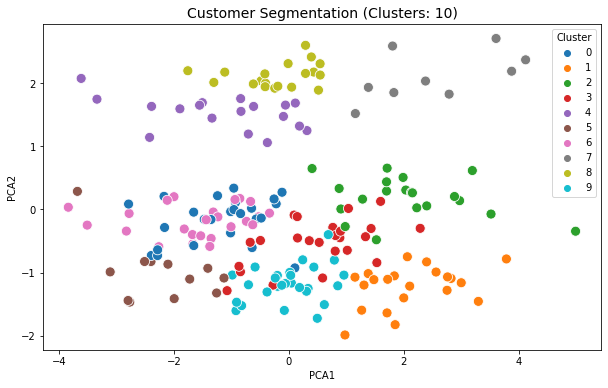

Optimal Number of Clusters: 10
Final DB Index: 1.02
Final Silhouette Score: 0.35


In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
customer_profile["PCA1"] = pca_result[:, 0]
customer_profile["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_profile,
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    palette="tab10",
    s=100
)
plt.title(f"Customer Segmentation (Clusters: {optimal_clusters})", fontsize=14)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()

# Save clustering results to a file
customer_profile.to_csv("Customer_Clusters.csv", index=False)

# Print results
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Final DB Index: {final_db_score:.2f}")
print(f"Final Silhouette Score: {final_sil_score:.2f}")

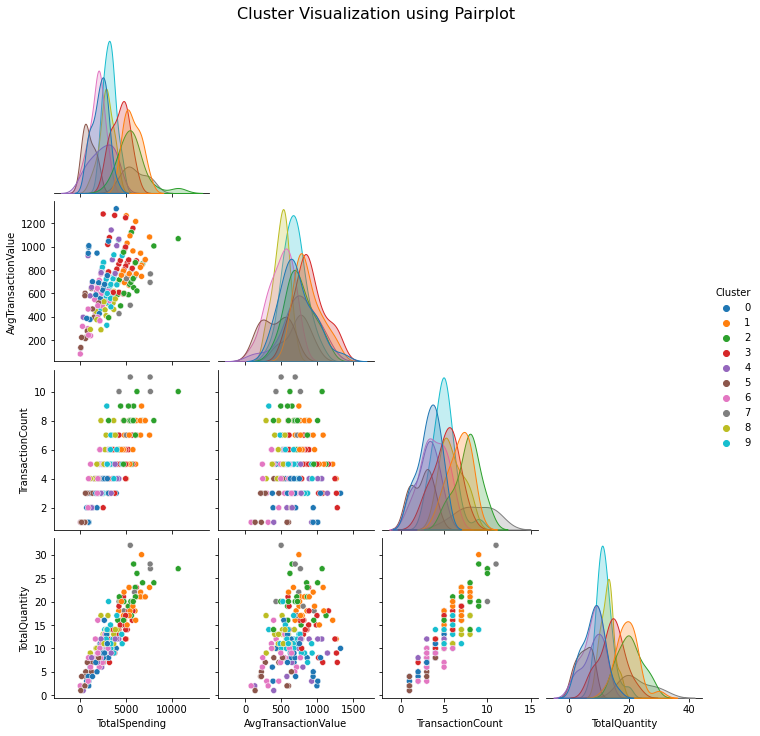

In [15]:
# Select a subset of features for visualization
selected_features = ["TotalSpending", "AvgTransactionValue", "TransactionCount", "TotalQuantity"]
subset = pd.concat([customer_profile[selected_features], customer_profile["Cluster"]], axis=1)

# Pairplot with hue as Cluster
sns.pairplot(subset, hue="Cluster", palette="tab10", diag_kind="kde", corner=True)
plt.suptitle("Cluster Visualization using Pairplot", y=1.02, fontsize=16)
plt.show()


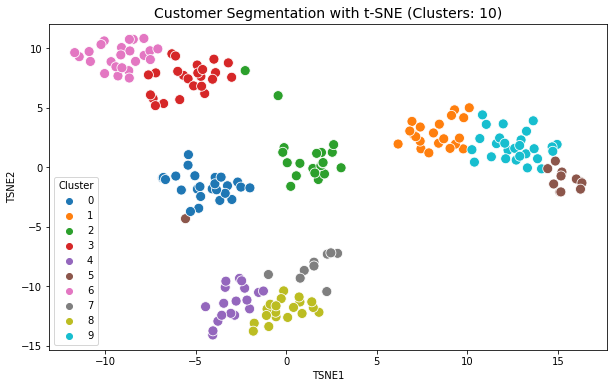

In [16]:
from sklearn.manifold import TSNE

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(X_scaled)

# Add t-SNE results to the customer profile for visualization
customer_profile["TSNE1"] = tsne_result[:, 0]
customer_profile["TSNE2"] = tsne_result[:, 1]

# Visualize clusters using t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_profile,
    x="TSNE1",
    y="TSNE2",
    hue="Cluster",
    palette="tab10",
    s=100
)
plt.title(f"Customer Segmentation with t-SNE (Clusters: {optimal_clusters})", fontsize=14)
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Cluster")
plt.show()


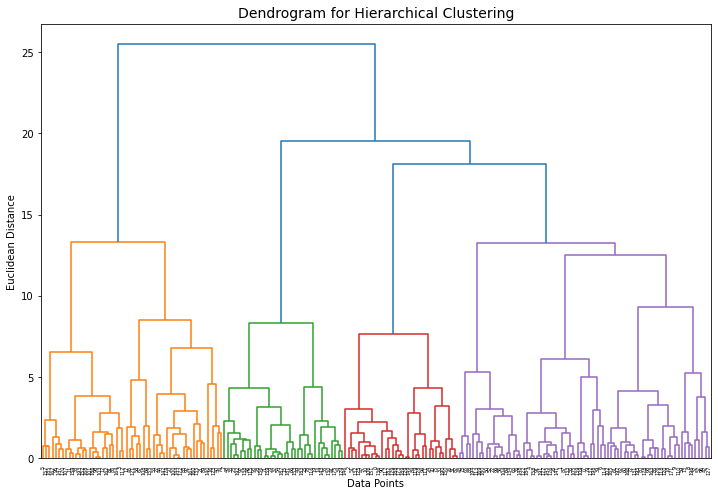

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
linked = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked, orientation='top', distance_sort='ascending', show_leaf_counts=False)
plt.title("Dendrogram for Hierarchical Clustering", fontsize=14)
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()